In [21]:
#format the book
from __future__ import division, print_function
%matplotlib inline
import sys
sys.path.insert(0, '..')
import book_format
book_format.set_style()

# Computing and plotting PDFs of discrete data

So let's investigate how to compute and plot probability distributions.


First, let's make some data according to a normal distribution. We use `numpy.random.normal` for this. The parameters are not well named. `loc` is the mean of the distribution, and `scale` is the standard deviation. We can call this function to create an arbitrary number of data points that are distributed according to that mean and std.

In [22]:
import numpy as np
import numpy.random as random

mean = 3
std = 2

data = random.normal(loc=mean, scale=std, size=50000)
print(len(data))
print(data.mean())
print(data.std())

50000
2.998755233965733
2.003650128432617


As you can see from the print statements we got 5000 points that have a mean very close to 3, and a standard deviation close to 2.

We can plot this Gaussian by using `scipy.stats.norm` to create a frozen function that we will then use to compute the pdf (probability distribution function) of the Gaussian.

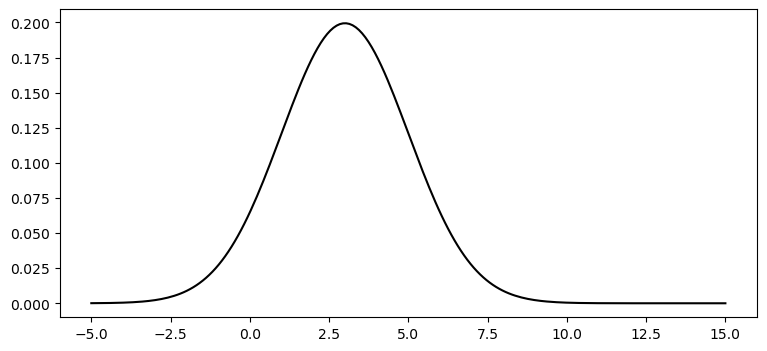

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats

def plot_normal(xs, mean, std, **kwargs):
    norm = stats.norm(mean, std)
    plt.plot(xs, norm.pdf(xs), **kwargs)

xs = np.linspace(-5, 15, num=200)
plot_normal(xs, mean, std, color='k')

But we really want to plot the PDF of the discrete data, not the idealized function.

There are a couple of ways of doing that. First, we can take advantage of `matplotlib`'s `hist` method, which computes a histogram of a collection of data. Normally `hist` computes the number of points that fall in a bin, like so:

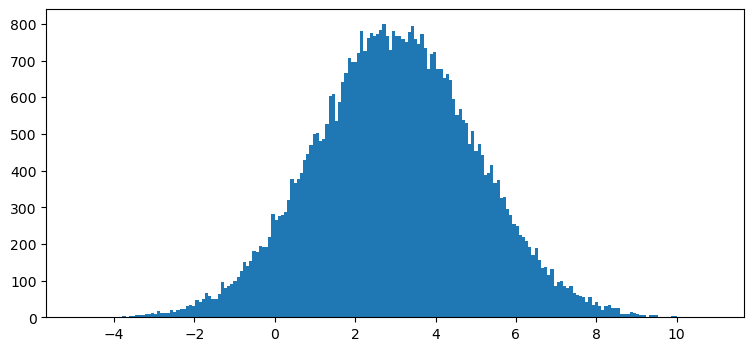

In [24]:
plt.hist(data, bins=200)
plt.show()

that is not very useful to us - we want the PDF, not bin counts. Fortunately `hist` includes a `density` parameter which will plot the PDF for us.

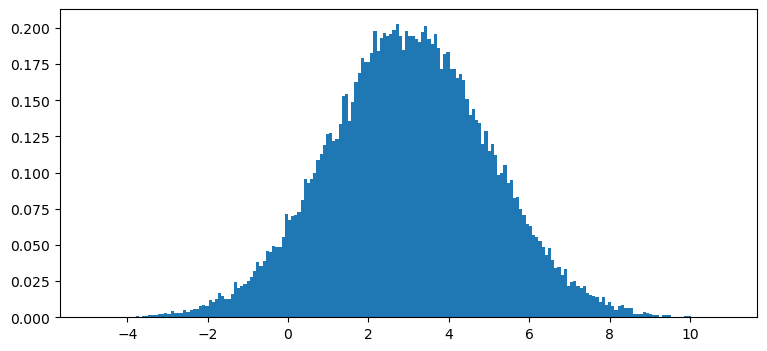

In [25]:
plt.hist(data, bins=200, density=True)
plt.show()

I may not want bars, so I can specify the `histtype` as 'step' to get a line.

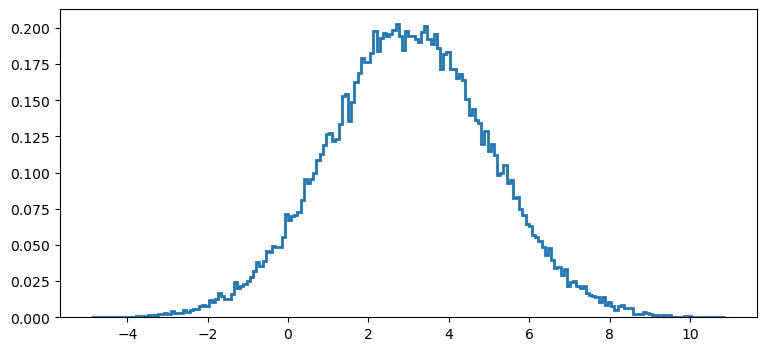

In [26]:
plt.hist(data, bins=200, density=True, histtype='step', lw=2)
plt.show()

To be sure it is working, let's also plot the idealized Gaussian in black.

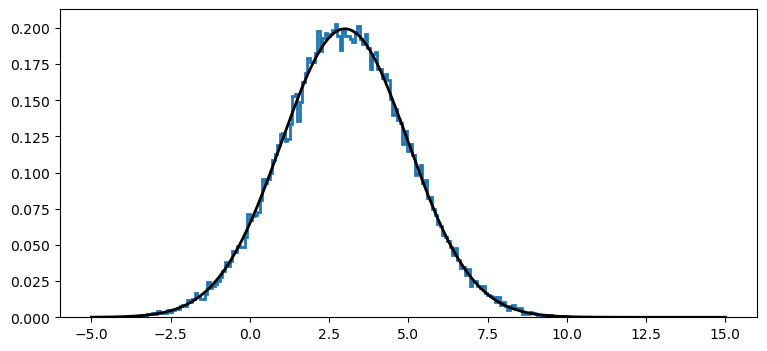

In [27]:
plt.hist(data, bins=200, density=True, histtype='step', lw=2)
norm = stats.norm(mean, std)
plt.plot(xs, norm.pdf(xs), color='k', lw=2)
plt.show()

There is another way to get the approximate distribution of a set of data. There is a technique called *kernel density estimate* that uses a kernel to estimate the probability distribution of a set of data. SciPy implements it with the function `gaussian_kde`. Do not be mislead by the name - Gaussian refers to the type of kernel used in the computation. This works for any distribution, not just Gaussians. In this section we have a Gaussian distribution, but soon we will not, and this same function will work.

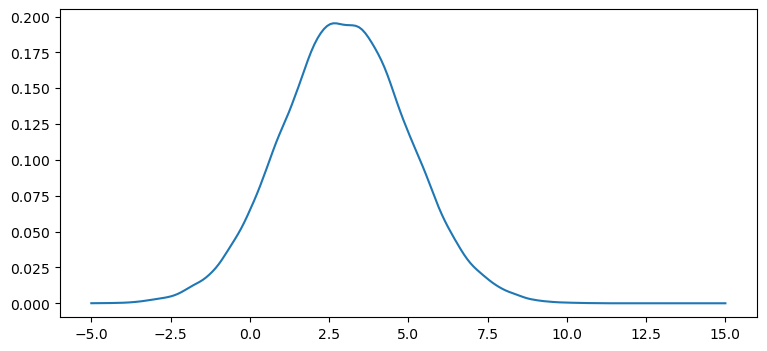

In [28]:
kde = stats.gaussian_kde(data)

xs = np.linspace(-5, 15, num=200)
plt.plot(xs, kde(xs))
plt.show()

## Monte Carlo Simulations


We (well I) want to do this sort of thing because I want to use monte carlo simulations to compute distributions. It is easy to compute Gaussians when they pass through linear functions, but difficult to impossible to compute them analytically when passed through nonlinear functions. Techniques like particle filtering handle this by taking a large sample of points, passing them through a nonlinear function, and then computing statistics on the transformed points. Let's do that.

We will start with the linear function $f(x) = 2x + 12$ just to prove to ourselves that the code is working. I will alter the mean and std of the data we are working with to help ensure the numbers that are output are unique It is easy to be fooled, for example, if the formula multipies x by 2, the mean is 2, and the std is 2. If the output of something is 4, is that due to the multication factor, the mean, the std, or a bug? It's hard to tell. 

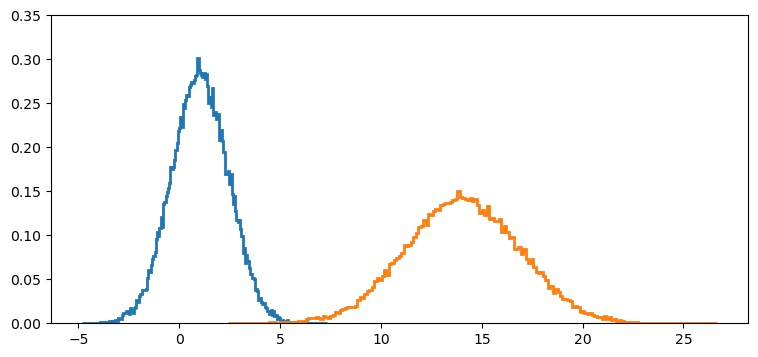

mean = 14.03
std  = 2.81


In [29]:
def f(x):
    return 2*x + 12

mean = 1.
std = 1.4
data = random.normal(loc=mean, scale=std, size=50000)

d_t = f(data) # transform data through f(x)

plt.hist(data, bins=200, density=True, histtype='step', lw=2)
plt.hist(d_t, bins=200, density=True, histtype='step', lw=2)

plt.ylim(0, .35)
plt.show()
print('mean = {:.2f}'.format(d_t.mean()))
print('std  = {:.2f}'.format(d_t.std()))

This is what we expected. The input is the Gaussian $\mathcal{N}(\mu=1, \sigma=1.4)$, and the function is $f(x) = 2x+12$. Therefore we expect the mean to be shifted to $f(\mu) = 2*1+12=14$. We can see from the plot and the print statement that this is what happened. 

Before I go on, can you explain what happened to the standard deviation? You may have thought that the new $\sigma$ should be passed through $f(x)$ like so $2(1.4) + 12=14.81$. But that is not correct - the standard deviation is only affected by the multiplicative factor, not the shift. If you think about that for a moment you will see it makes sense. We multiply our samples by 2, so they are twice as spread out as before. Standard deviation is a measure of how spread out things are, so it should also double. It doesn't matter if we then shift that distribution 12 places, or 12 million for that matter - the spread is still twice the input data.



## Nonlinear Functions

Now that we believe in our code, lets try it with nonlinear functions.

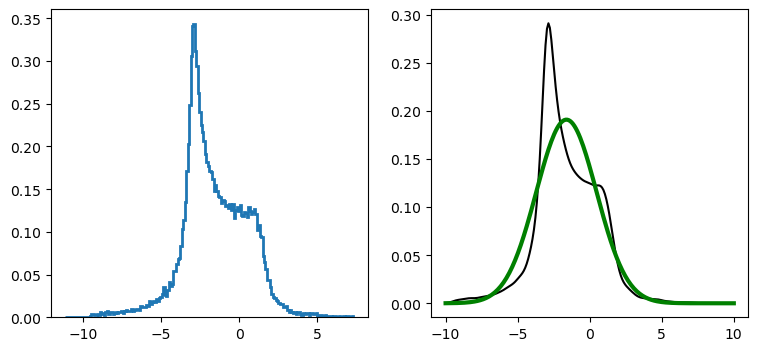

mean = -1.61
std  = 2.09


In [30]:
def f2(x):
    return (np.cos((1.5*x + 2.1))) * np.sin(x/3) - 1.6*x

d_t = f2(data)
plt.subplot(121)
plt.hist(d_t, bins=200, density=True, histtype='step', lw=2)

plt.subplot(122)
kde = stats.gaussian_kde(d_t)
xs = np.linspace(-10, 10, 200)
plt.plot(xs, kde(xs), 'k')
plot_normal(xs, d_t.mean(), d_t.std(), color='g', lw=3)
plt.show()
print('mean = {:.2f}'.format(d_t.mean()))
print('std  = {:.2f}'.format(d_t.std()))

Here I passed the data through the nonlinear function $f(x) = \cos(1.5x+2.1)\sin(\frac{x}{3}) - 1.6x$. That function is quite close to linear, but we can see how much it alters the pdf of the sampled data. 

There is a lot of computation going on behind the scenes to transform 50,000 points and then compute their PDF. The Extended Kalman Filter (EKF) gets around this by linearizing the function at the mean and then passing the Gaussian through the linear equation. We saw above how easy it is to pass a Gaussian through a linear function. So lets try that.

We can linearize this by taking the derivative of the function at x. We can use sympy to get the derivative. 

In [31]:
import sympy
x = sympy.symbols('x')
f = sympy.cos(1.5*x+2.1) * sympy.sin(x/3) - 1.6*x
dfx = sympy.diff(f, x)
dfx

-1.5*sin(x/3)*sin(1.5*x + 2.1) + cos(x/3)*cos(1.5*x + 2.1)/3 - 1.6

We can now compute the slope of the function by evaluating the derivative at the mean.

In [32]:
m = dfx.subs(x, mean)
m

-1.66528051815545

The equation of a line is $y=mx+b$, so the new standard deviation should be $~1.67$ times the input std. We can compute the new mean by passing it through the original function because the linearized function is just the slope of f(x) evaluated at the mean. The slope is a tangent that touches the function at $x$, so both will return the same result. So, let's plot this and compare it to the results from the monte carlo simulation.

In [37]:
f2(mean)

-1.8934145981318489

In [38]:

abs(float(m)*std)

2.3313927254176274

In [39]:
d_t.mean()

-1.6148042202457884

In [40]:
d_t.std()

2.0904112090017453

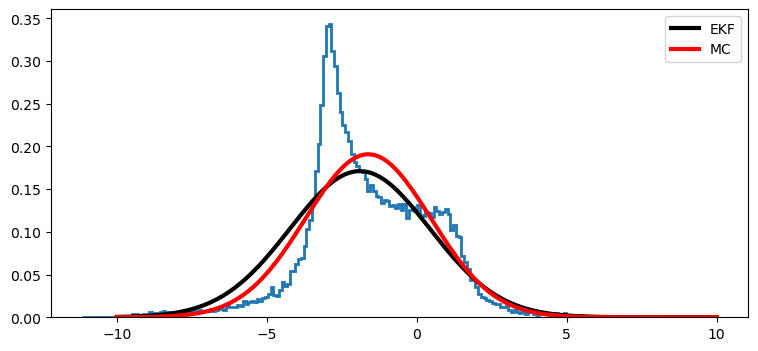

In [33]:
plt.hist(d_t, bins=200, density=True, histtype='step', lw=2)
plot_normal(xs, f2(mean), abs(float(m)*std), color='k', lw=3, label='EKF')
plot_normal(xs, d_t.mean(), d_t.std(), color='r', lw=3, label='MC')
plt.legend()
plt.show()

We can see from this that the estimate from the EKF (in red) is not exact, but it is not a bad approximation either. 